## 신규 구매 데이터 생성
* 실제 예측해야할 내용은 유지가 아닌 신규 구매 상품이 어떤 것인지 임

In [2]:
import pandas as pd
import numpy as np

In [3]:
#훈련 데이터 reading
trn = pd.read_csv('/home/jeongchanwoo/workspace/git/study/Kaggle_data/santander-product-recommendation/input/train_ver2.csv')

/home/jeongchanwoo/miniconda3/envs/ml_python_linux/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trn.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [5]:
# 제품 변수를 probs에 list 형태로 저장
prods = trn.columns[24:].tolist()

In [6]:
# 날짜를 숫자로 변환
def date_to_int(str_date):
    Y,M,D = [int(a) for a in str_date.strip().split("-")]
    int_date = (int(Y) - 2015) * 12 + int(M)
    return int_date

In [7]:
# 날짜를 숫자로 변환하여 int_date에 저장
trn['int_date'] = trn['fecha_dato'].map(date_to_int).astype(np.int8)


In [8]:
#데이터를 복사하고 int_date 날짜에 1을 더하여 lag를 생성. 변수명에 _prev추가
trn_lag = trn.copy()
trn_lag['int_date'] +=1
trn_lag.columns = [col + '_prev' if col not in ['ncodpers', 'int_date'] else col for col in trn.columns]

In [9]:
trn_lag.head()

,fecha_dato_prev,ncodpers,ind_empleado_prev,pais_residencia_prev,sexo_prev,age_prev,fecha_alta_prev,ind_nuevo_prev,antiguedad_prev,indrel_prev,...,ind_plan_fin_ult1_prev,ind_pres_fin_ult1_prev,ind_reca_fin_ult1_prev,ind_tjcr_fin_ult1_prev,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev,int_date
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2


In [10]:
#원본 데이터와 lag 데이터를 ncodper, int_date 기준으로 합침. 저번달 정보도 반영됨
df_trn = trn.merge(trn_lag, on = ['ncodpers', 'int_date'], how='left')

In [11]:
del trn, trn_lag

In [12]:
# 저번 달 제품 정보가 존재하지 않을 경우 0으로 대체
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)
    
#원본 데이터 제품 보유 여부, lag 데이터 제품 보유 여부를 비교해 신규 구매 변수 padd 구함
for prod in prods:
    padd = prod + '_add'
    prev = prod + '_prev'
    df_trn[padd] = ((df_trn[prod]==1) & (df_trn[prev]==0)). astype(np.int8)

In [13]:
# 신규 구매 변수만을 추출해 labels에 저장
add_cols = [prod + '_add' for prod in prods]
labels = df_trn[add_cols].copy()
labels.columns = prods
labels.to_csv('/home/jeongchanwoo/workspace/git/study/Kaggle_data/santander-product-recommendation/input/labels.csv', index = False)

In [14]:
labels.tail()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
13647304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13647305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13647306,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13647307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13647308,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 월별 신규 구매 데이터 누적 막대 시각화


In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [16]:
labels = pd.read_csv('/home/jeongchanwoo/workspace/git/study/Kaggle_data/santander-product-recommendation/input/labels.csv').astype(int)
fecha_dato = pd.read_csv('/home/jeongchanwoo/workspace/git/study/Kaggle_data/santander-product-recommendation/input/train_ver2.csv', usecols=['fecha_dato'])

In [17]:
fecha_dato.head()

,fecha_dato
0,2015-01-28
1,2015-01-28
2,2015-01-28
3,2015-01-28
4,2015-01-28


In [18]:
labels['date'] = fecha_dato.fecha_dato
months = np.unique(fecha_dato.fecha_dato).tolist()
label_cols = labels.columns.tolist()[:24]

In [19]:
label_over_time= []
for i in range(len(label_cols)):
    label_over_time.append(labels.groupby(['date']) [label_cols[i]].agg('sum').tolist())

In [20]:
label_sum_over_time=[]
for i in range(len(label_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))


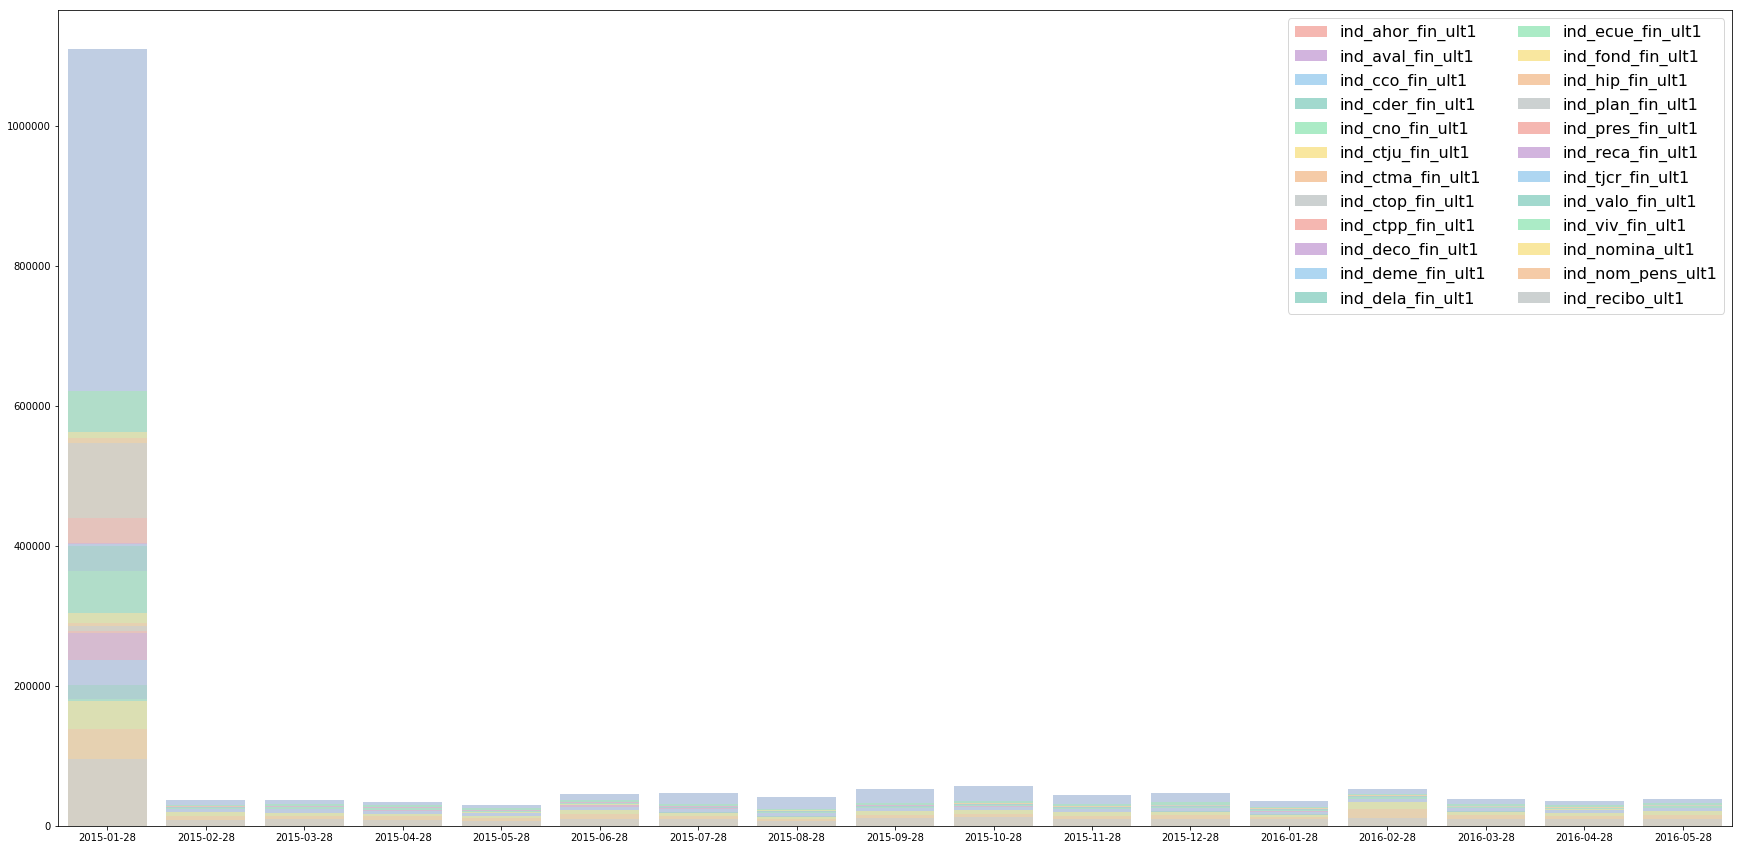

In [21]:
color_list = ['#F5B7B1', '#D2B4DE', '#AED6F1','#A2D9CE', '#ABEBC6' ,'#F9E79F', '#F5CBA7','#CCD1D1']

f, ax = plt.subplots(figsize = (30,15))
for i in range(len(label_cols)):
    #24개 제품에 대한 히스토그램
    # x축은 우러 데이터, y 축은 누적 총합, 색깔은 8개 번갈아, alpha는 0.7 지정
    
    sns.barplot(x = months, y = label_sum_over_time[i], color= color_list[i%8],  alpha = 0.7)
    
    
#legend  추가
plt.legend([plt.Rectangle((0,0),1,1, fc= color_list[i%8], edgecolor = 'none') for i in range(len(label_cols))], label_cols , loc = 1, ncol = 2, prop = {'size' : 16})

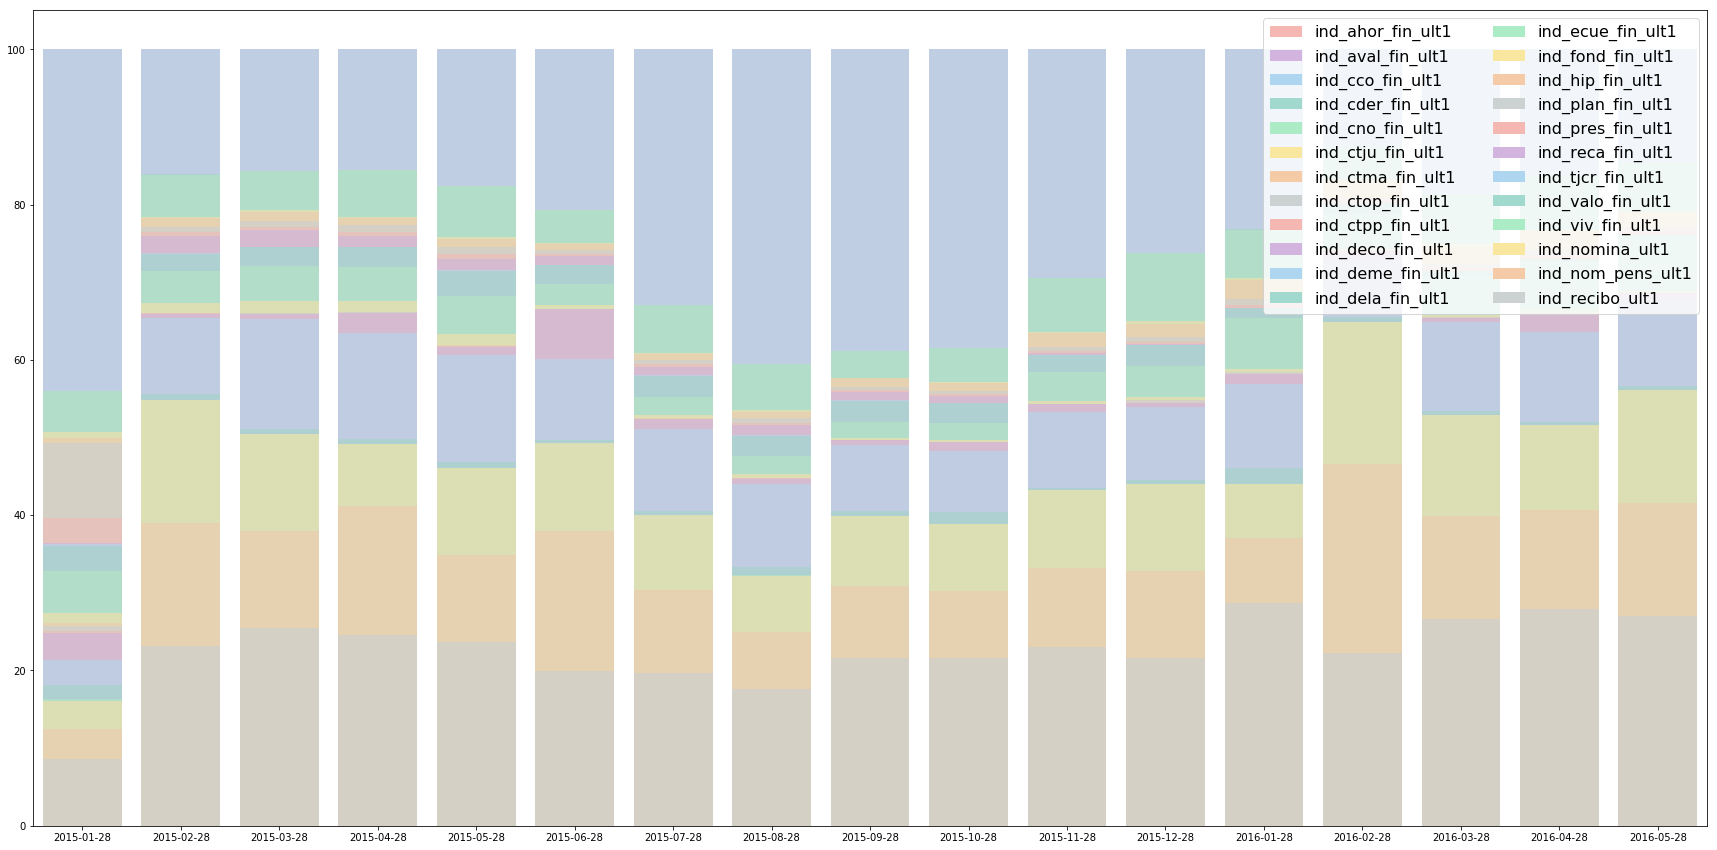

In [22]:
# label_sum_over_time 값을 퍼센트 단위로 변환. 월마다 최댓값으로 나누고 100을 곱함
label_sum_percent = (label_sum_over_time / (1.*np.asarray(label_sum_over_time).max(axis=0)))*100

f, ax = plt.subplots(figsize = (30,15))
for i in range(len(label_cols)):
    #24개 제품에 대한 히스토그램
    # x축은 우러 데이터, y 축은 누적 총합, 색깔은 8개 번갈아, alpha는 0.7 지정
    
    sns.barplot(x = months, y = label_sum_percent[i], color=color_list[i%8], alpha = 0.7)
    
    
#legend  추가
plt.legend([plt.Rectangle((0,0),1,1, fc= color_list[i%8], edgecolor = 'none') for i in range(len(label_cols))], label_cols , loc = 1, ncol = 2, prop = {'size' : 16})